In [ ]:
import pandas as pd, numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc
font = {'size': 12}
matplotlib.rc('font', **font)
import seaborn as sns
from google.colab import files

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
df = pd.read_csv('dataset_bc.csv')
df.columns,

(Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
        'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
        'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
        'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
        'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
        'fractal_dimension_se', 'radius_worst', 'texture_worst',
        'perimeter_worst', 'area_worst', 'smoothness_worst',
        'compactness_worst', 'concavity_worst', 'concave points_worst',
        'symmetry_worst', 'fractal_dimension_worst'],
       dtype='object'),)

In [ ]:
df.shape, df.isna().values.sum()

((569, 32), 7)

In [ ]:
df = df.dropna()
df.shape

(562, 32)

In [ ]:
df.diagnosis.value_counts(),

(diagnosis
 B    354
 M    208
 Name: count, dtype: int64,)

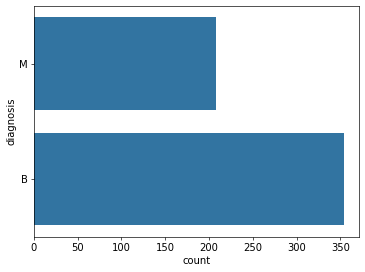

In [ ]:
plt.figure(figsize=(7, 5), dpi=60)
ax = sns.countplot(df.diagnosis)

<Figure size 120x80 with 0 Axes>

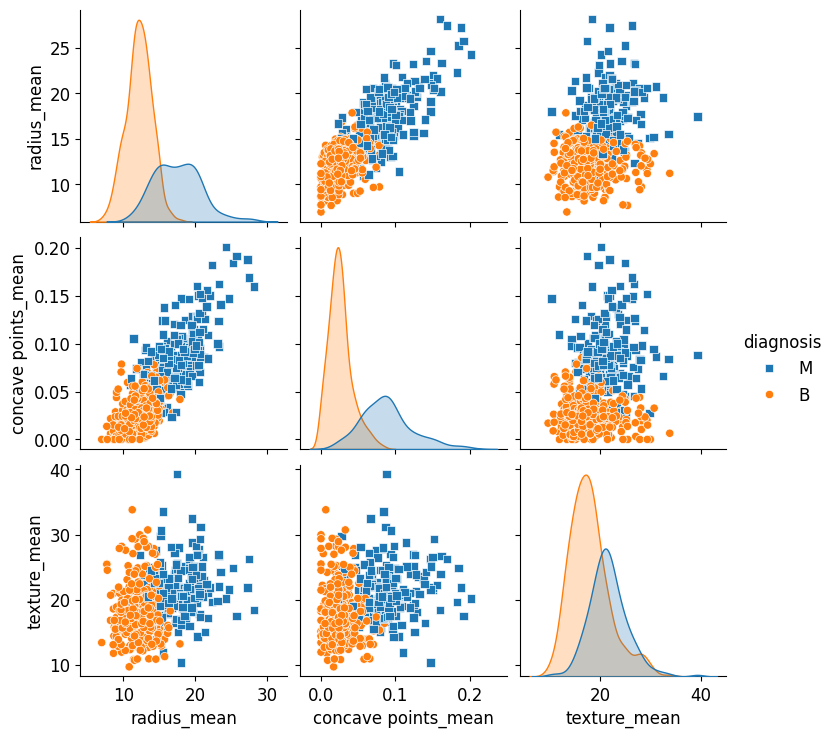

In [ ]:
plt.figure(figsize=(6,4), dpi=20)
ax = sns.pairplot(df[['diagnosis', 'radius_mean', 'concave points_mean', 'texture_mean']],
             hue='diagnosis', markers=['s', 'o'])

In [ ]:
''' outliers '''
df_malignant = df[df.diagnosis == 'M']
df_benign = df[df.diagnosis == 'B']
q1_ = df_malignant['radius_mean'].quantile(0.25)
q3_ = df_malignant['radius_mean'].quantile(0.75)
iqr_ = q3_ - q1_
lower_bound_ = q1_ - 1.5 * iqr_
upper_bound_ = q3_ + 1.5 * iqr_
lower_bound_, upper_bound_

(8.268749999999997, 26.418750000000003)

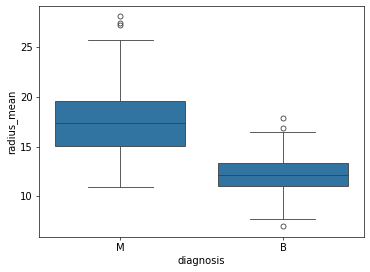

In [ ]:
plt.figure(figsize=(7, 5), dpi=60)
ax = sns.boxplot(x='diagnosis', y='radius_mean', data=df)

In [ ]:
dl_benign = df[df['diagnosis'] =='B']['radius_mean']
dl_malignant = df[df['diagnosis'] =='M']['radius_mean']
above_benign = dl_benign[dl_benign < lower_bound_]
below_benign = dl_malignant[dl_malignant > upper_bound_]
len(np.concatenate([above_benign, below_benign], axis=0)), \
np.concatenate([above_benign, below_benign], axis=0)

(9,
 array([ 8.196,  6.981,  8.219,  7.729,  7.691,  7.76 , 27.22 , 28.11 ,
        27.42 ]))

<Axes: >

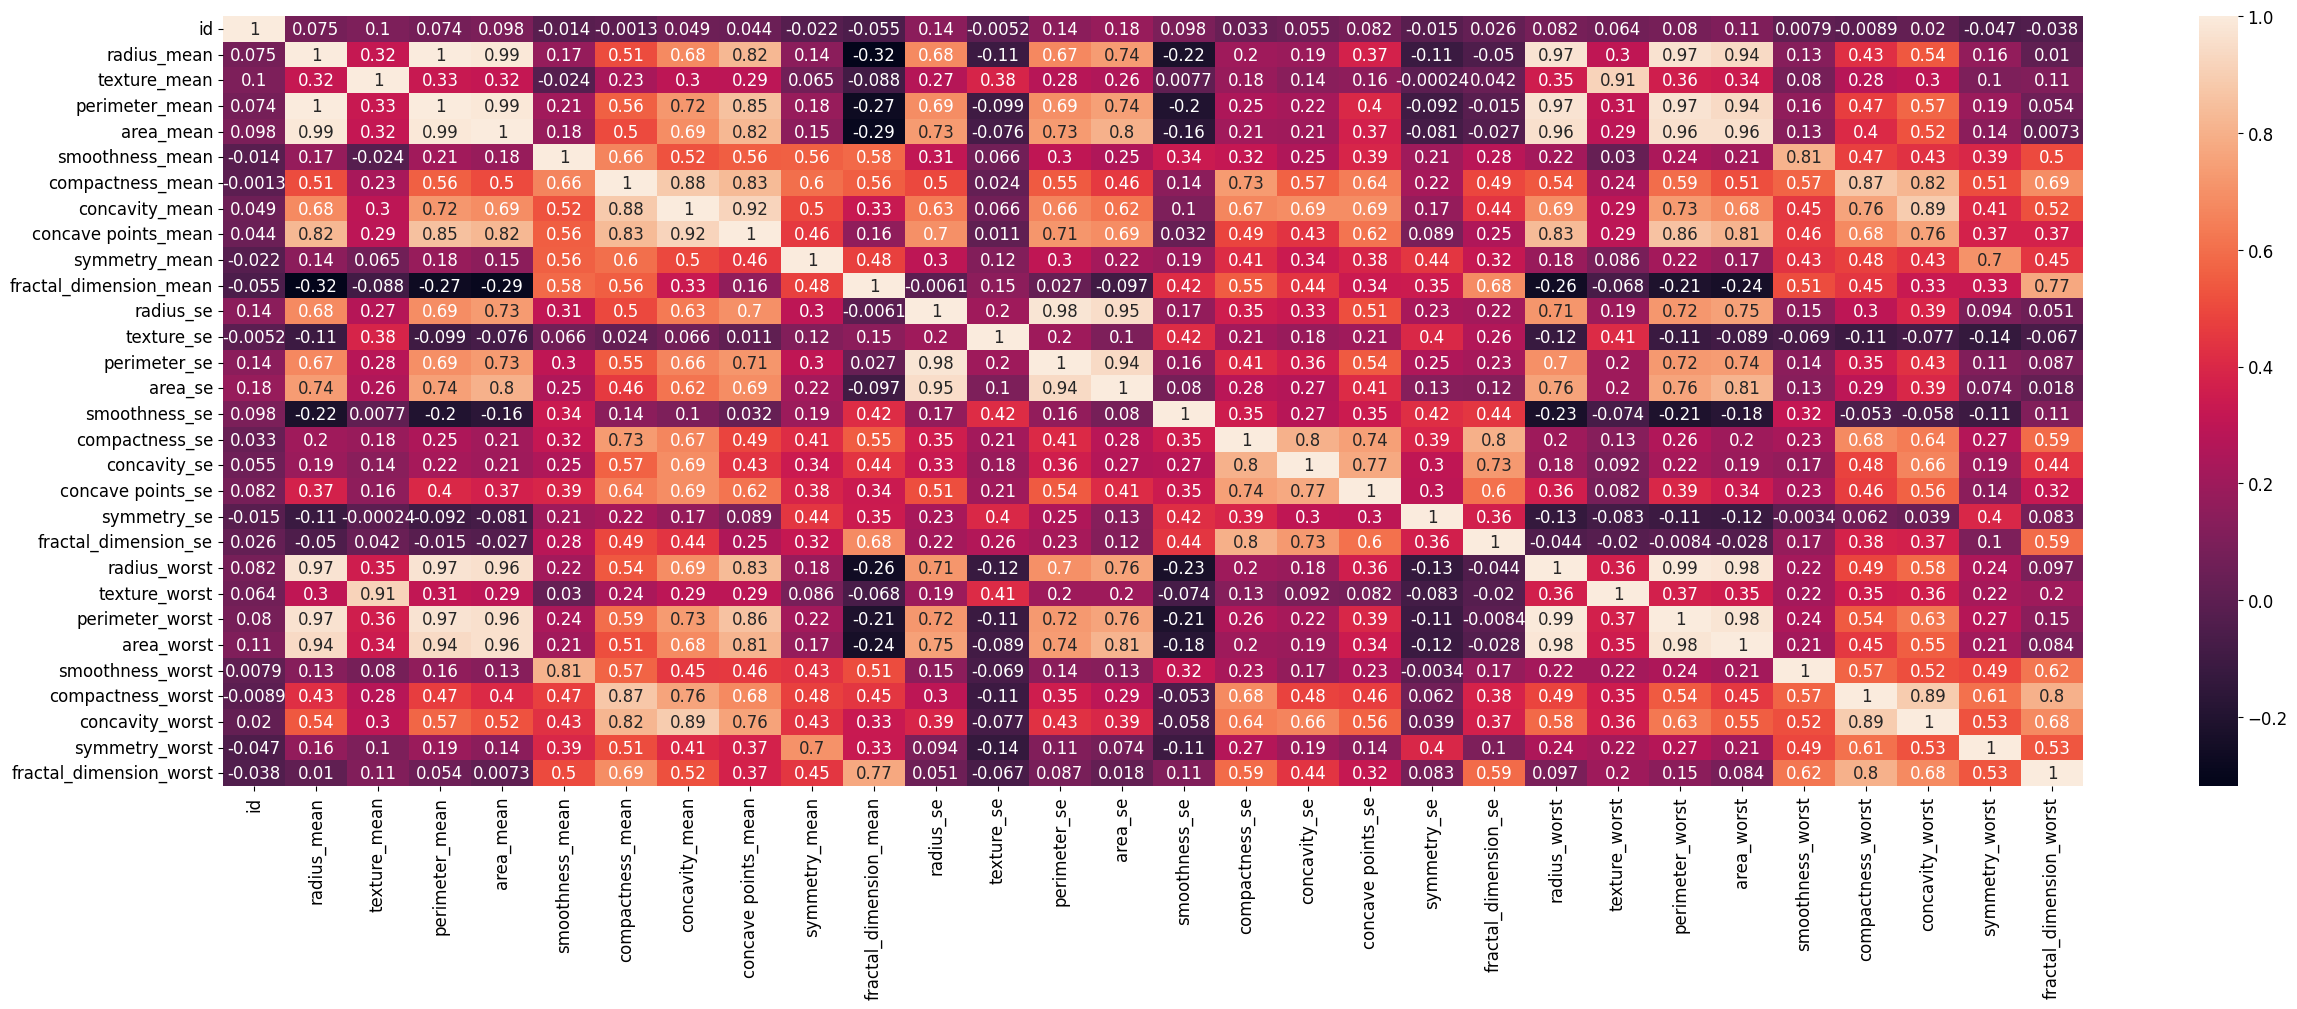

In [ ]:
numerical_features = df.select_dtypes(include=np.number).columns
numerical_df = df[numerical_features]
fig, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(numerical_df.corr(), annot=True, ax=ax)

In [ ]:
''' remove correlations '''
corr_matrix = numerical_df.corr().abs()
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(
    upper_triangle[column] > 0.95)]
numerical_df.drop(to_drop, axis=1, inplace=True)
df.drop(to_drop, axis=1, inplace=True)
to_drop

<ipython-input-284-1b7ea05a8b9f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_df.drop(to_drop, axis=1, inplace=True)


['perimeter_mean',
 'area_mean',
 'perimeter_se',
 'area_se',
 'radius_worst',
 'perimeter_worst',
 'area_worst']

Text(0.5, 1.0, 'Breast cancer correlation map')

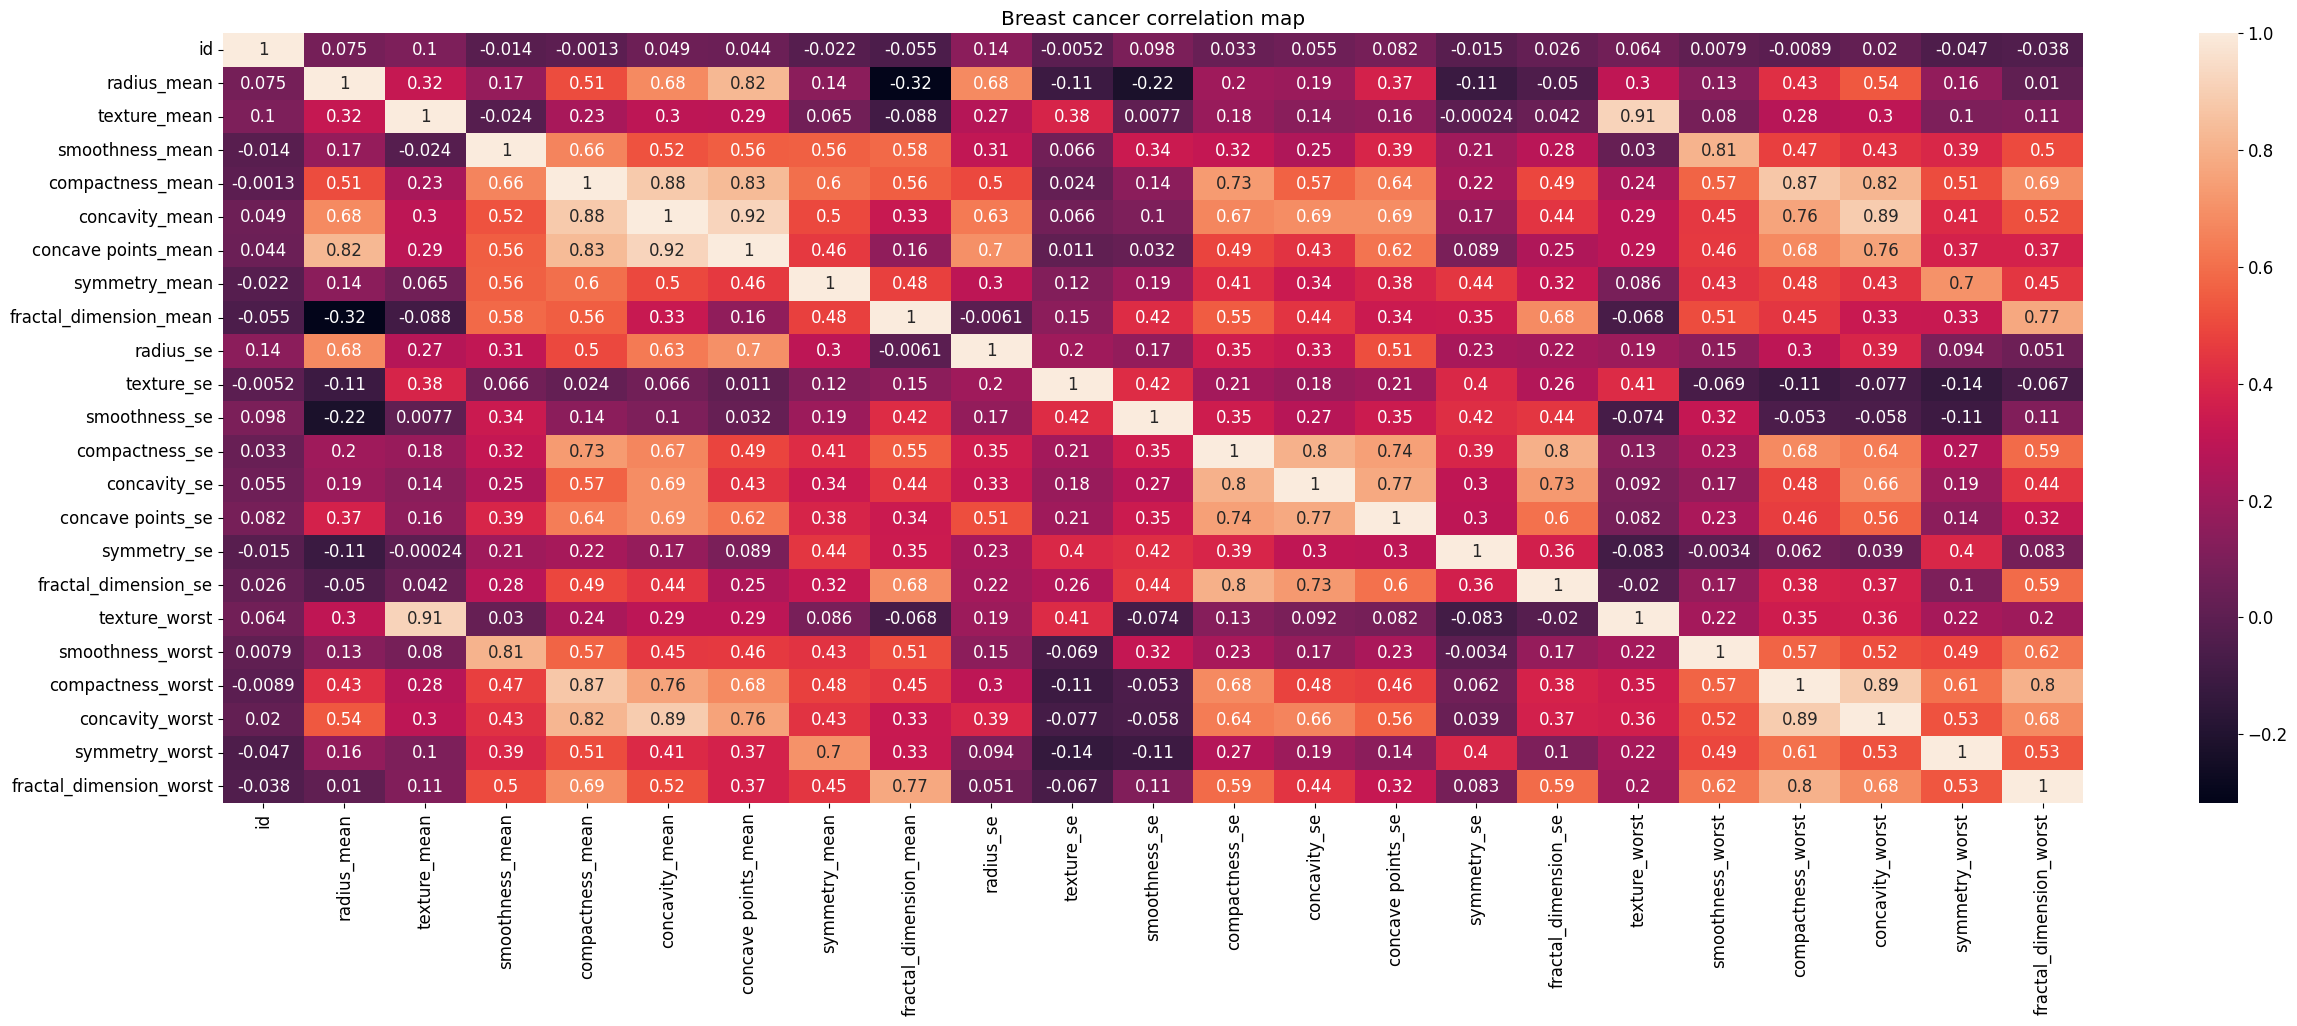

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
ax = sns.heatmap(numerical_df.corr(), annot=True, ax=ax)
plt.title('Breast cancer correlation map')

Clustering

Model development and Validation

In [ ]:
''' Gaussian Naive Bayes '''
nm_df = df.select_dtypes(include=np.number).columns
X_ = df[nm_df].drop(columns =['id'])
y = df.diagnosis.values
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_), columns=X_.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=40)
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train, y_train)
y_gnb_pred = gnb_classifier.predict(X_test)
print('accuracy score', accuracy_score(y_test, y_gnb_pred))

accuracy score 0.950354609929078


In [ ]:
''' Random Forest Classifier '''
random_forest_classifier = RandomForestClassifier(random_state=40) #, max_depth=8)
random_forest_classifier.fit(X_train, y_train)
y_pred = random_forest_classifier.predict(X_test)
print('accuracy score', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

accuracy score 0.9929078014184397
              precision    recall  f1-score   support

           B       0.99      1.00      0.99        95
           M       1.00      0.98      0.99        46

    accuracy                           0.99       141
   macro avg       0.99      0.99      0.99       141
weighted avg       0.99      0.99      0.99       141



In [ ]:
''' Save/load the Scaler '''
import pickle
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [ ]:
loadingscaler = pickle.load(open('scaler.pkl', 'rb'))

In [ ]:
''' Save/load the Model '''
pickle.dump(gnb_classifier, open('gnb_classifier.pkl', 'wb'))
pickle.dump(random_forest_classifier, open('random_forest_classifier.pkl', 'wb'))
loading_gnb_classifier = pickle.load(open('gnb_classifier.pkl', 'rb'))
loading_random_forest_classifier = pickle.load(open('random_forest_classifier.pkl', 'rb'))
loading_gnb_classifier.score(X_test, y_test), \
loading_random_forest_classifier.score(X_test, y_test)

(0.950354609929078, 0.9929078014184397)

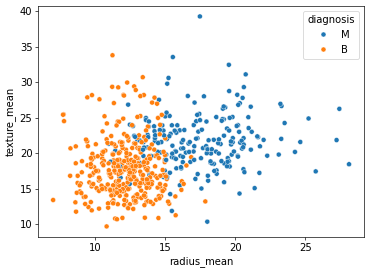

In [ ]:
plt.figure(figsize=(7, 5), dpi=60)
ax = sns.scatterplot(x='radius_mean', y='texture_mean', hue='diagnosis', data=df)

Agglomerative Clustering

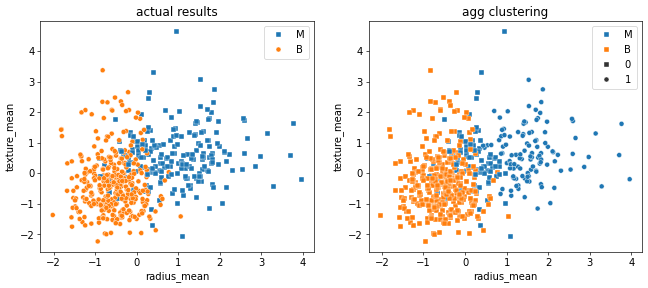

In [ ]:
from sklearn.cluster import AgglomerativeClustering
agg_cluster = AgglomerativeClustering(n_clusters=2, linkage='ward')
agg_cluster_allpreds = agg_cluster.fit_predict(X_scaled.iloc[:, :2])

plt.figure(figsize=(20, 5), dpi=60)
plt.subplot(131)
plt.title('actual results')
ax = sns.scatterplot(x='radius_mean', y='texture_mean', hue=y,
                     data=X_scaled, style=y, markers=['s', 'o'])
ax.legend(loc='upper right')
plt.subplot(132)
plt.title('agg clustering')
ax = sns.scatterplot(x='radius_mean', y='texture_mean', hue=y,
                     data=X_scaled, style=agg_cluster_allpreds, markers=['s', 'o'])
ax.legend(loc='upper right')


KMeans clustering

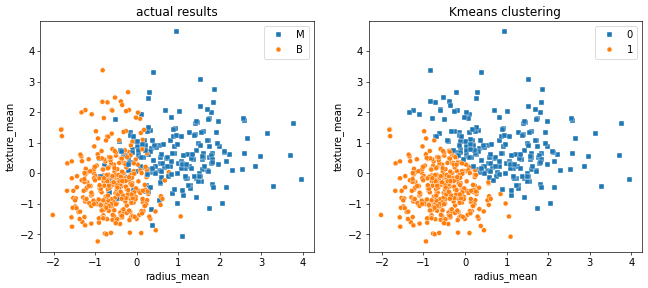

In [ ]:
from sklearn.cluster import KMeans
kmeans_cluster = KMeans(n_clusters=2, n_init=10, init='k-means++')
kmeans_cluster_preds = kmeans_cluster.fit_predict(X_scaled.iloc[:, :2])
kmeans_cluster_preds_inv = 1 - kmeans_cluster_preds

plt.figure(figsize=(20, 5), dpi=60)
plt.subplot(131)
plt.title('actual results')
ax = sns.scatterplot(x='radius_mean', y='texture_mean', hue=y,
                     data=X_scaled, style=y, markers=['s', 'o'])
ax.legend(loc='upper right')

plt.subplot(132)
plt.title('Kmeans clustering')
ax = sns.scatterplot(x='radius_mean', y='texture_mean', hue=kmeans_cluster_preds,
                     data=X_scaled, style=kmeans_cluster_preds, markers=['s', 'o'])
ax.legend(loc='upper right')



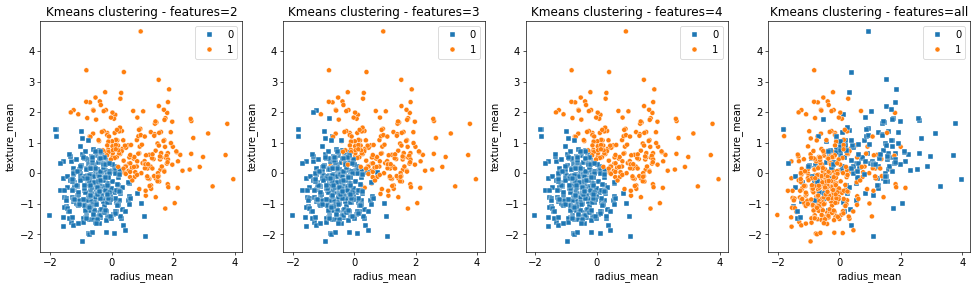

In [ ]:
kmeans_cluster_preds_2 = kmeans_cluster.fit_predict(X_scaled.iloc[:, :2])
kmeans_cluster_preds_3 = kmeans_cluster.fit_predict(X_scaled.iloc[:, :3])
kmeans_cluster_preds_4 = kmeans_cluster.fit_predict(X_scaled.iloc[:, :2])
kmeans_cluster_preds_all = kmeans_cluster.fit_predict(X_scaled.iloc[:, :])

plt.figure(figsize=(20, 5), dpi=60)

plt.subplot(141)
plt.title('Kmeans clustering - features=2')
ax = sns.scatterplot(
    x='radius_mean', y='texture_mean', hue=kmeans_cluster_preds_2,
    data=X_scaled, style=kmeans_cluster_preds_2, markers=['s', 'o'])
ax.legend(loc='upper right')

plt.subplot(142)
plt.title('Kmeans clustering - features=3')
ax = sns.scatterplot(
    x='radius_mean', y='texture_mean', hue=kmeans_cluster_preds_3,
    data=X_scaled, style=kmeans_cluster_preds_3, markers=['s', 'o'])
ax.legend(loc='upper right')

plt.subplot(143)
plt.title('Kmeans clustering - features=4')
ax = sns.scatterplot(
    x='radius_mean', y='texture_mean', hue=kmeans_cluster_preds_4,
    data=X_scaled, style=kmeans_cluster_preds_4, markers=['s', 'o'])
ax.legend(loc='upper right')

plt.subplot(144)
plt.title('Kmeans clustering - features=all')
ax = sns.scatterplot(
    x='radius_mean', y='texture_mean', hue=kmeans_cluster_preds_all,
    data=X_scaled, style=kmeans_cluster_preds_all, markers=['s', 'o'])
ax.legend(loc='upper right')


<ipython-input-302-b16582fdbd7b>:11: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(
<ipython-input-302-b16582fdbd7b>:18: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(
<ipython-input-302-b16582fdbd7b>:25: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(
<ipython-input-302-b16582fdbd7b>:32: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(


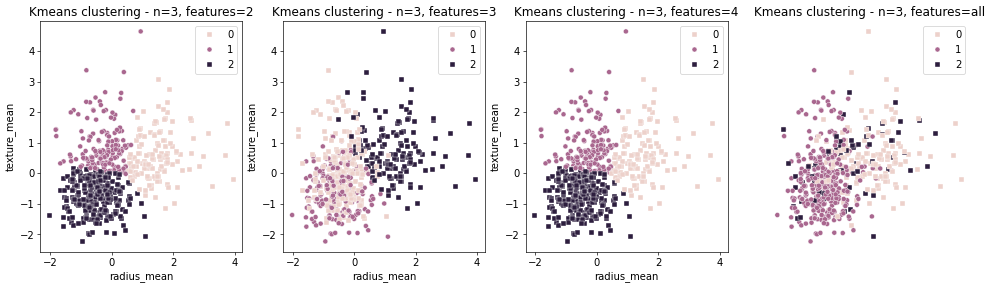

In [ ]:
kmeans_cluster = KMeans(n_clusters=3, n_init=10, init='k-means++')
kmeans_cluster_preds_2 = kmeans_cluster.fit_predict(X_scaled.iloc[:, :2])
kmeans_cluster_preds_3 = kmeans_cluster.fit_predict(X_scaled.iloc[:, :3])
kmeans_cluster_preds_4 = kmeans_cluster.fit_predict(X_scaled.iloc[:, :2])
kmeans_cluster_preds_all = kmeans_cluster.fit_predict(X_scaled.iloc[:, :])

plt.figure(figsize=(20, 5), dpi=60)

plt.subplot(141)
plt.title('Kmeans clustering - n=3, features=2')
ax = sns.scatterplot(
    x='radius_mean', y='texture_mean', hue=kmeans_cluster_preds_2,
    data=X_scaled, style=kmeans_cluster_preds_2, markers=['s', 'o'])
ax.legend(loc='upper right')

plt.subplot(142)
plt.title('Kmeans clustering - n=3, features=3')
ax = sns.scatterplot(
    x='radius_mean', y='texture_mean', hue=kmeans_cluster_preds_3,
    data=X_scaled, style=kmeans_cluster_preds_3, markers=['s', 'o'])
ax.legend(loc='upper right')

plt.subplot(143)
plt.title('Kmeans clustering - n=3, features=4')
ax = sns.scatterplot(
    x='radius_mean', y='texture_mean', hue=kmeans_cluster_preds_4,
    data=X_scaled, style=kmeans_cluster_preds_4, markers=['s', 'o'])
ax.legend(loc='upper right')

plt.subplot(144)
plt.title('Kmeans clustering - n=3, features=all')
ax = sns.scatterplot(
    x='radius_mean', y='texture_mean', hue=kmeans_cluster_preds_all,
    data=X_scaled, style=kmeans_cluster_preds_all, markers=['s', 'o'])
ax.legend(loc='upper right')
plt.axis('off')
plt.show()

Application

In [ ]:
import flask
from flask import Flask, jsonify, request

In [ ]:
loading_gnb_classifier = pickle.load(open('gnb_classifier.pkl', 'rb'))
loading_random_forest_classifier = pickle.load(open('random_forest_classifier.pkl', 'rb'))

In [ ]:
labels = ['radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'concavity_mean', 'concave points_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se',
       'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se',
       'symmetry_se', 'fractal_dimension_se', 'texture_worst',
       'smoothness_worst', 'compactness_worst', 'concavity_worst',
       'symmetry_worst', 'fractal_dimension_worst']

In [ ]:
loadingscaler = pickle.load(open('scaler.pkl', 'rb'))
input_df.columns = labels
input_scaled = loadingscaler.transform(input_df)
input_scaled

array([[-0.76452751,  0.25467585,  3.27908846,  3.43400337,  1.91840058,
        -1.25447989, 13.50261219,  4.95126388,  0.32657144, -0.10487163,
         0.68579181,  2.78348135,  0.82456191, -1.93178843, -0.22181865,
        21.33869425, -4.18264573,  3.40038912,  3.99299042,  2.01551539,
         6.05923896,  5.15403296]])

In [ ]:
prediction = loading_gnb_classifier.predict(input_scaled)
prediction

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


array(['B'], dtype='<U1')

In [ ]:
prediction_ = loading_random_forest_classifier.predict(input_scaled)
prediction_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array(['B'], dtype=object)

In [ ]:
def diagnosis_predict(inputdata, scaler, model):
  input_df = pd.DataFrame([inputdata])
  input_df.columns = labels
  scaled_input = scaler.transform(input_df)
  prediction = model.predict(input_scaled)
  return prediction[0]

In [ ]:
input = [11.42, 20.38, 0.14250, 0.28390, 0.2414, 0.2597, 0.551277, 0.09744, 0.4956, 1.1560, 0.009110, 0.07458, 0.05661, 0.276978, 0.01867, 0.05963, 0.009208, 0.2098, 0.8663, 0.6869, 0.6638, 0.17300]
diagnosis_predict(input, loadingscaler, loading_random_forest_classifier)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


'B'

We could perform model training with fewer data

Run the application

In [ ]:
import json

app = Flask(__name__)
@app.route('/')
def get_index():
  return 'Breast Cancer Prediction application'

'''
@app.route('/api/echo/<value>')
def post_echo(value):
  return f"you entered '{value}' "  #jsonify(value=value)
'''
@app.route('/api/predict', methods=['POST'])
def post_echo():
  inputdata = json.loads(request.data)
  inputfeatures = inputdata['text']
  prediction = diagnosis_predict(
      inputdata, loadingscaler, loading_random_forest_classifier)
  return 'Malignant' if prediction =='M' else 'Benign'

if __name__ == '__main__':
  app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.6.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

 Copyright (c) 2007-2024 The scikit-learn developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

 * Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

 THIS SOFTWARE IS PROVIDED BY THE COPYR